# Sprawozdanie - szyfry blokowe

## Bartosz Skrzypczak 155832

In [20]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import padding
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


key = os.urandom(16)
iv = os.urandom(16)
backend = default_backend()

In [13]:
sizes = [1024, 1024*1024, 5*1024*1024]  # 1KB, 1MB, 5MB
file_paths = ["plik1.bin", "plik2.bin", "plik3.bin"]

for size, path in zip(sizes, file_paths):
    with open(path, "wb") as f:
        f.write(os.urandom(size))

In [14]:
file_paths = ["plik1.bin", "plik2.bin", "plik3.bin"]
data_samples = []

for path in file_paths:
    with open(path, "rb") as f:
        data = f.read()
        data_samples.append(data)

# Sprawdźmy ile bajtów wczytano
for i, data in enumerate(data_samples):
    print(f"Plik {i+1}: {len(data)} bajtów")

Plik 1: 1024 bajtów
Plik 2: 1048576 bajtów
Plik 3: 5242880 bajtów


In [15]:
def pad(data):
    padder = padding.PKCS7(128).padder()
    return padder.update(data) + padder.finalize()

def unpad(data):
    unpadder = padding.PKCS7(128).unpadder()
    return unpadder.update(data) + unpadder.finalize()

In [16]:
modes_list = {
    'ECB': lambda: modes.ECB(),
    'CBC': lambda: modes.CBC(iv),
    'CFB': lambda: modes.CFB(iv),
    'OFB': lambda: modes.OFB(iv),
    'CTR': lambda: modes.CTR(iv)
}

results = {}

for mode_name, mode_func in modes_list.items():
    times = []
    for data in data_samples:
        padded_data = pad(data)
        cipher = Cipher(algorithms.AES(key), mode_func(), backend=backend)
        encryptor = cipher.encryptor()
        decryptor = cipher.decryptor()

        start_enc = time.time()
        ciphertext = encryptor.update(padded_data) + encryptor.finalize()
        end_enc = time.time()

        start_dec = time.time()
        plaintext = decryptor.update(ciphertext) + decryptor.finalize()
        plaintext = unpad(plaintext)
        end_dec = time.time()

        times.append( (end_enc-start_enc, end_dec-start_dec) )
    results[mode_name] = times

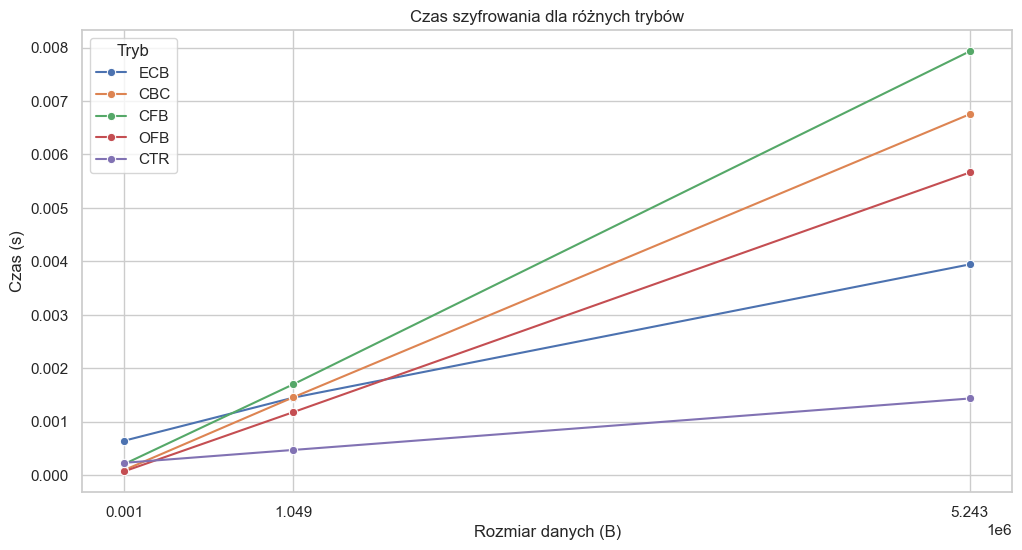

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sizes = [1024, 1024*1024, 5*1024*1024]

df = []
for mode, times in results.items():
    for i, (enc, dec) in enumerate(times):
        df.append({
            "Tryb": mode, 
            "Rozmiar": sizes[i],
            "Szyfrowanie": enc, 
            "Deszyfrowanie": dec
        })

df = pd.DataFrame(df)

sns.set(style="whitegrid")
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=df, x="Rozmiar", y="Szyfrowanie", hue="Tryb", marker="o")
plt.title("Czas szyfrowania dla różnych trybów")
plt.xlabel("Rozmiar danych (B)")
plt.ylabel("Czas (s)")
ax.set_xticks(sizes)
plt.show()


#  Interpretacja wyników pomiarów czasów szyfrowania
Na podstawie przeprowadzonych pomiarów można zauważyć, że czas szyfrowania danych rośnie liniowo wraz z rozmiarem danych we wszystkich trybach pracy. Jest to zgodne z oczekiwaniami, ponieważ większa ilość danych wymaga wykonania większej liczby operacji szyfrujących.

Najkrótsze czasy szyfrowania osiągają tryby ECB oraz CTR.

- ECB (Electronic Codebook) szyfruje każdy blok niezależnie, co eliminuje konieczność dodatkowych operacji między blokami.

- CTR (Counter) działa w trybie strumieniowym, generując pseudolosowy ciąg bloków na podstawie licznika i XOR-ując go z danymi. Dzięki temu może być bardzo wydajny i łatwo zrównoleglany.

- CBC (Cipher Block Chaining) osiąga czasy pośrednie. Wynika to z konieczności wykonywania operacji XOR z poprzednim blokiem szyfrogramu przed zaszyfrowaniem kolejnego bloku. Pomimo tego, przy większych danych jego wydajność nie spada aż tak mocno jak w trybie CFB.

Najwolniejszym trybem w przeprowadzonych pomiarach okazał się CFB (Cipher Feedback). W tym trybie każdy blok danych jest szyfrowany po wcześniejszym zaszyfrowaniu poprzedniego szyfrogramu i wykonaniu operacji XOR z bieżącym blokiem tekstu jawnego. Ta sekwencyjna zależność powoduje znaczne spowolnienie, szczególnie dla dużych plików.

OFB (Output Feedback) osiągał czasy lepsze niż CFB, ponieważ działa w trybie strumieniowym, w którym szyfrowane są kolejne wyniki szyfrowania poprzedniego wektora inicjalizacyjnego lub szyfrogramu, a nie dane jawne. Dzięki temu eliminuje się część zależności pomiędzy danymi a operacjami szyfrowania.

Podsumowując:

 - CTR i ECB są najszybsze.

 - CBC osiąga czasy pośrednie.

 - OFB jest nieco wolniejszy od CBC.

 - CFB wypada najwolniej w tych pomiarach, ze względu na sekwencyjny charakter działania i dodatkowe operacje przy każdym bloku.

Wyniki te są zgodne z charakterystyką algorytmów, przy czym rzeczywiste czasy mogą różnić się w zależności od implementacji, rozmiaru segmentów w trybie CFB i wydajności sprzętowej.

In [23]:

print("Propagacja błędów:")
for mode_name, mode_func in modes_list.items():
    data = pad(data_samples[0])
    cipher = Cipher(algorithms.AES(key), mode_func(), backend=backend)
    encryptor = cipher.encryptor()
    ciphertext = encryptor.update(data) + encryptor.finalize()

    corrupted = bytearray(ciphertext)
    corrupted[10] ^= 0x01

    decryptor = cipher.decryptor()
    try:
        decrypted = decryptor.update(bytes(corrupted)) + decryptor.finalize()
        decrypted = unpad(decrypted)
        print(f"{mode_name}: OK")
    except Exception as e:
        print(f"{mode_name}: Błąd deszyfrowania ({str(e)})")


Propagacja błędów:
ECB: OK
CBC: OK
CFB: OK
OFB: OK
CTR: OK


# Analiza propagacji błędów w różnych trybach szyfrów blokowych


## 1. Tryb ECB (Electronic Codebook)
W trybie ECB każdy blok danych jest szyfrowany niezależnie od innych. Oznacza to, że:

- Błąd w szyfrogramie (np. zmiana jednego bajtu w szyfrogramie) wpłynie tylko na ten konkretny blok.

- Po deszyfrowaniu tego bloku zostanie on niepoprawnie odszyfrowany (np. jako losowy ciąg danych), ale reszta wiadomości pozostanie niezależna i nienaruszona.

### Wnioski:

- Błąd w szyfrogramie spowoduje, że tylko jeden blok będzie odszyfrowany niepoprawnie.

- Cała wiadomość jest wciąż częściowo czytelna, bo pozostałe bloki zostaną odszyfrowane poprawnie.

## 2. Tryb CBC (Cipher Block Chaining)
W trybie CBC, jak wiadomo, każdy blok danych jest zależny od poprzedniego bloku szyfrogramu. Błąd w szyfrogramie wpłynie na cały proces szyfrowania i deszyfrowania:

- Błąd w szyfrogramie (np. zmiana jednego bajtu) wpłynie na bieżący blok oraz na następny blok.

Jeśli zmieni się blok w szyfrogramie, to przy deszyfrowaniu:

- Bieżący blok zostanie odszyfrowany niepoprawnie, ponieważ będzie XOR-owany z błędnym szyfrogramem poprzedniego bloku.

- Następny blok będzie także błędnie odszyfrowany, ponieważ poprzedni blok, na którym opiera się jego szyfrowanie, będzie zawierał błąd.

### Wnioski:

- Błąd w szyfrogramie wpłynie na jeden blok i na następny.

- Fragment wiadomości po błędzie stanie się nieczytelny, ponieważ zmiana jednego bajtu w szyfrogramie może zniekształcić dane w dwóch blokach.

- Poziom zniekształcenia zależy od tego, gdzie dokładnie wystąpił błąd, ale część wiadomości zostanie utracona.

## 3. Tryb OFB (Output Feedback)
W trybie OFB operacje szyfrowania są przeprowadzane na strumieniu generowanym przez poprzedni szyfrogram. Błąd w szyfrogramie:

- Błąd w szyfrogramie wpłynie tylko na bieżący blok. Po zmianie jednego bajtu w szyfrogramie, tylko ten blok zostanie odszyfrowany niepoprawnie.

W następnych blokach strumień szyfrujący będzie poprawny, ponieważ błędny blok nie wpływa na generowanie kolejnych bloków szyfrujących.

### Wnioski:

- Błąd w szyfrogramie wpłynie tylko na jeden blok.

- Cała wiadomość, oprócz tego błędnego bloku, pozostanie nienaruszona i poprawnie odszyfrowana.

## 4. Tryb CFB (Cipher Feedback)
Tryb CFB jest podobny do OFB, ale działa na fragmentach tekstu (np. po bajcie). Błąd w szyfrogramie:

- Błąd w szyfrogramie wpłynie na bieżący blok, a dodatkowo może wpłynąć na kolejny blok.

Tak jak w trybie CBC, zmiana jednego bajtu może powodować zmiany w kolejnych blokach — zwłaszcza przy większych jednostkach (np. 8-bitowych lub 128-bitowych fragmentach).

### Wnioski:

- Błąd w szyfrogramie może wpłynąć na bieżący blok i na następny.

- Fragment wiadomości może stać się nieczytelny w wyniku błędu.

## 5. Tryb CTR (Counter)
W trybie CTR generowanie pseudolosowego strumienia za pomocą licznika powoduje, że:

- Błąd w szyfrogramie wpłynie tylko na jeden blok. Zmiana jednego bajtu w szyfrogramie zmieni tylko ten blok po deszyfrowaniu, ponieważ szyfrowanie i deszyfrowanie zależą od strumienia.

Pozostała część wiadomości nie zostanie zniekształcona, ponieważ każdy blok jest szyfrowany niezależnie.

### Wnioski:

- Błąd w szyfrogramie wpłynie tylko na jeden blok.

- Cała wiadomość poza tym blokiem pozostanie nienaruszona i poprawnie odszyfrowana.

In [7]:

def cbc_encrypt_ecb(key, iv, data):
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=backend)
    encryptor = cipher.encryptor()

    padded_data = pad(data)
    blocks = [padded_data[i:i+16] for i in range(0, len(padded_data), 16)]
    ciphertext = b''
    prev = iv

    for block in blocks:
        xored = bytes(a ^ b for a, b in zip(block, prev))
        enc_block = encryptor.update(xored)
        ciphertext += enc_block
        prev = enc_block

    return ciphertext

def cbc_decrypt_ecb(key, iv, ciphertext):
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=backend)
    decryptor = cipher.decryptor()

    blocks = [ciphertext[i:i+16] for i in range(0, len(ciphertext), 16)]
    plaintext = b''
    prev = iv

    for block in blocks:
        dec_block = decryptor.update(block)
        xored = bytes(a ^ b for a, b in zip(dec_block, prev))
        plaintext += xored
        prev = block

    return unpad(plaintext)

data = data_samples[0]
enc = cbc_encrypt_ecb(key, iv, data)
dec = cbc_decrypt_ecb(key, iv, enc)
print("CBC na bazie ECB działa poprawnie:", dec == data)


CBC na bazie ECB działa poprawnie: True
